<a href="https://colab.research.google.com/github/Zobia12/EEG_Based_Human_Emotion_Recognition_Using_Deep_Learning/blob/main/EEG_based_Emotion_Recognition_Using_LSTM_model(with_32_channels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-vow37i04
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-vow37i04


In [ ]:

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [ ]:
channel = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] #32 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/My Drive/LEADING_AI/DATA/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/LEADING_AI/DATA/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/LEADING_AI/DATA/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 4 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/LEADING_AI/70_30/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/LEADING_AI/70_30/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/LEADING_AI/70_30/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/LEADING_AI/70_30/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (43920, 155) (43920, 4)
testing dataset: (14640, 155) (14640, 4)


In [ ]:

with open('/content/drive/My Drive/LEADING_AI/70_30/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/LEADING_AI/70_30/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [ ]:
X.shape

(43920, 155)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train = np.array(X[:])

In [ ]:

with open('/content/drive/My Drive/LEADING_AI/70_30/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/LEADING_AI/70_30/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
x_test = np.array(M[:])

In [ ]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(43920, 155, 1)

In [ ]:
batch_size = 256
num_classes = 10
epochs = 250
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(155, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
  from keras.regularizers import l2
  from keras.layers import Bidirectional
  from keras.layers import LSTM

  model = Sequential()
 
  model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
  model.add(Dropout(0.6))

  model.add(LSTM(units = 256, return_sequences = True))  
  model.add(Dropout(0.6))

  model.add(LSTM(units = 64, return_sequences = True))  
  model.add(Dropout(0.6))

  model.add(LSTM(units = 64, return_sequences = True))  
  model.add(Dropout(0.4))

  model.add(LSTM(units = 32))
  model.add(Dropout(0.4))

  model.add(Dense(units = 16))
  model.add(Activation('relu'))

  model.add(Dense(units = num_classes))
  model.add(Activation('softmax'))
  model.compile(optimizer ="adam", loss =keras.losses.categorical_crossentropy,metrics=["accuracy"])
  model.summary()
  m=model.fit(x_train, y_train,epochs=250,batch_size=256,verbose=1,validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 155, 256)         133120    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 155, 256)          0         
                                                                 
 lstm_21 (LSTM)              (None, 155, 256)          525312    
                                                                 
 dropout_21 (Dropout)        (None, 155, 256)          0         
                                                                 
 lstm_22 (LSTM)              (None, 155, 64)           82176     
                                                                 
 dropout_22 (Dropout)        (None, 155, 64)           0         
                                                      

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

458/458 [==============================] - 9s 20ms/step - loss: 0.4725 - accuracy: 0.8787
Test loss: 0.4725044369697571
Test accuracy: 0.8786885142326355


In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


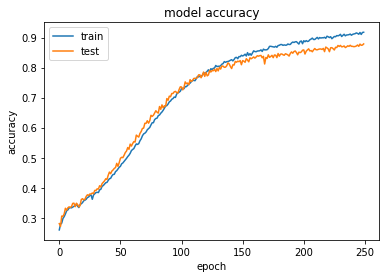

In [ ]:
import matplotlib.pyplot as plt
print(m.history.keys())
# summarize history for accuracy
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


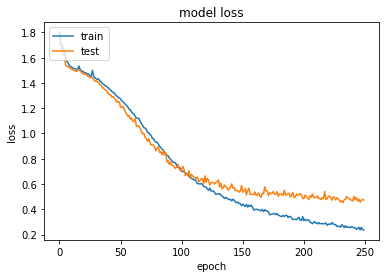

In [ ]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

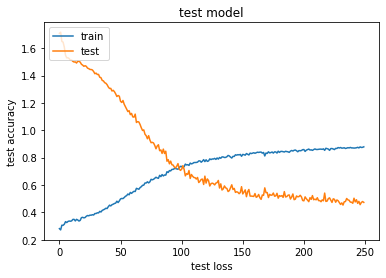

In [136]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np
y_test1=np.argmax(y_test, axis=1)

458/458 [==============================] - 9s 19ms/step


In [ ]:
y_pred1=np.argmax(y_pred,axis=1)

In [ ]:
y_pred1.shape

(14640,)

In [ ]:
y_test1.shape

(14640,)

In [ ]:
cmatrix=confusion_matrix(y_test1, y_pred1)

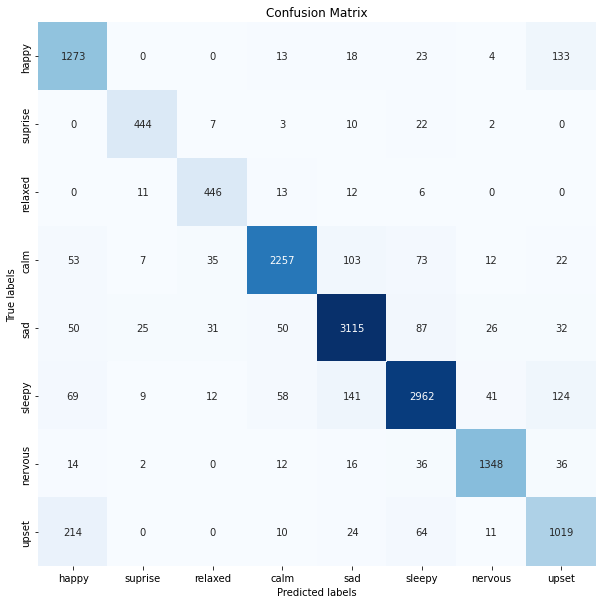

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cmatrix, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues );  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["happy", "suprise", "relaxed","calm", "sad", "sleepy","nervous","upset"]);
ax.yaxis.set_ticklabels(["happy", "suprise", "relaxed","calm", "sad", "sleepy","nervous","upset"]);

In [ ]:
# Load the library    
from tensorflow.keras.models import load_model
# Save the model using TensorFlow SavedModel format
model.save('/content/drive/My Drive/LEADING_AI/70_30/fft_lstm_75-25_model_liking.h5')